#![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Assignment 1 - Beyond word count**
# **Word Transition counts**
#### In the first assignment, we will continue from the word count example covered in class. Assume you are designing a smart keyboard app, and would like to predict the next word based on the last word entered. To do this, we need to estimate transition probabilities of words. In the simplest case, we would like to know the most likely word to follow any given word. Normally, such a list would be built using the users emails, and prior text entry etc. For the purposes of this assignment, build a simple data structure that computes the number of times word2 follows word1. Effectively, you need something similar to the word count, that looks like ((word1. word2), n). Use the same text we used for the word count example, [The Adventures of Sherlock Holmes](http://norvig.com/big.txt) by Sir Arthur Conan Doyle. 
#### Note that, for reference, you can look up the details of the relevant methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)

In [5]:
import os.path
# baseDir = os.path.join('CS6965_data')
inputPath = os.path.join('big.txt')
fileName = os.path.join(baseDir, inputPath)

In [6]:
import re
def removePunctuation(text):
    """Removes punctuation, changes to lower case, and strips leading and trailing spaces.

    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated (e.g. it's becomes its).  Leading and trailing spaces should be removed after
        punctuation is removed.

    Args:
        text (str): A string.

    Returns:
        str: The cleaned up string.
    """
    text = re.sub(r'[^\w\s]','',text)
    return text.lower().strip().trim()

In [75]:
sherlockRDD = (sc.textFile(fileName, 8).map(removePunctuation))
sherlockRDD = sherlockRDD \
                .glom() \
                .map(lambda x: " ".join(x)) \
                .flatMap(lambda x: x.split(".")
                )

In [94]:
#filter out the empty elements.  Remove all entries where the word is `''`.
sherlockWordsRDD = sherlockRDD.map(lambda s: s.split(" "))
sherlockBigramRDD = sherlockWordsRDD.flatMap(lambda s: [(s[i],s[i+1]) for i in range(0,len(s)-1)])
sherlockFilteredBigramRDD = sherlockBigramRDD.filter(lambda s: len(s[0]) > 4 and len(s[1]) > 4)
print sherlockFilteredBigramRDD.take(5)

[(u'project', u'gutenberg'), (u'gutenberg', u'ebook'), (u'sherlock', u'holmes'), (u'arthur', u'conan'), (u'conan', u'doyle')]


In [25]:
def wordCount(wordListRDD):
    """Creates a pair RDD with word counts from an RDD of words.

    """
    return wordListRDD.map(lambda x: (x,1)).reduceByKey(lambda x, y: x + y)

top10WordsAndCounts =  wordCount(sherlockFilteredBigramRDD).takeOrdered(10, lambda x: -x[1])

In [96]:
print '\n'.join(map(lambda (w, c): '{0}: {1}'.format(w, c), top10WordsAndCounts))

(u'prince', u'andrew'): 976
(u'united', u'states'): 422
(u'prince', u'vasili'): 196
(u'project', u'gutenbergtm'): 126
(u'project', u'gutenberg'): 113
(u'mademoiselle', u'bourienne'): 106
(u'sherlock', u'holmes'): 99
(u'takes', u'place'): 97
(u'prince', u'andrews'): 89
(u'marya', u'dmitrievna'): 88
(u'little', u'princess'): 73
(u'united', u'states_'): 71
(u'granulation', u'tissue'): 69
(u'synovial', u'membrane'): 69
(u'blood', u'vessels'): 67


# **Text similarity**
#### Due to problems downloading the gutenberg files, I have changed to using the [British Corpus - 451 books](http://dhresourcesforprojectbuilding.pbworks.com/w/page/69244469/Data%20Collections%20and%20Datasets). I was able to run the similarity problem using all 451 books on my laptop with 8GB of RAM in under a minute. I am interested in computing how similar these books are, by a metric of my choice. We shall define similarity between books based on two metrics, 
####Jaccard Distance
####Cosine distance
####In order to do this, we will define features for each book. For the Jaccard distance, we define this as the intersection/union of the words used in the two books that I am comparing. For the cosine distance, we will first compute the words used in all the books, then select the top 1000 (or some small subset) most used words as a feature vector. For each book, the normalized word counts for these selected 1000 words will be used for the cosine distance, i.e., the similarity between any two books is the inner or dot product of these normalized feature vectors ((a,b)=∑aibi). By normalized, I mean that the feature vector for each book should have a magnitude of 1.  In. python

In [97]:
from numpy import array
from numpy.linalg import norm 

a = array([1.0, 1.0, 0.6])
b = a/norm(a)
# b = array([ 0.65094455,  0.65094455,  0.39056673])

####You should include the similarity matrices plotted as an images in your report. Refer to this page for using matplotlib to render a matrix as an image. Also include a similarity matrices as a text file (ascii) along with your submission. 

In [1]:
books = sc.wholeTextFiles("scrubbed/*.txt")

In [2]:
bookRDD = books.mapValues(lambda x: x.replace('\n', '').split(" "))

In [3]:
bookWordsRDD = bookRDD.mapValues(lambda x: [x[i] for i in range(0, len(x)-1) if len(x[i]) > 3 ])

In [4]:
#import collections
#bookWordCountRDD = bookWordsRDD.mapValues(lambda x: collections.Counter(x).most_common(1000))

In [5]:
#bookTopWordsRDD = bookWordCountRDD.mapValues(lambda x: [x[i][0] for i in range(0, len(x)-1)])                                    

In [76]:
bookPairsRDD = bookWordsRDD.cartesian(bookWordsRDD)

In [77]:
def jaccardSimilarity(tup):
    
    set1 = set(tup[0][1]).intersection(set(tup[1][1]))
    set2 = set(tup[0][1]).union(set(tup[1][1]))
    return float(len(set1))/float(len(set2))

In [78]:
bookJaccardRDD = bookPairsRDD.map(lambda x: (x[0][0],jaccardSimilarity(x)))

In [79]:
bookJaccardMatRDD = bookJaccardRDD.map(lambda (x,y): (x, [y])).reduceByKey(lambda p,q: p+q)

In [80]:
bookJaccardMatrixRDD = bookJaccardMatRDD.map(lambda x: x[1])

In [63]:
import numpy as np
from numpy.linalg import norm 

def cosineSimilarity(a,b, top1000):
    "Build word to vec"
    a_w = [a.get(str(word), 0) for word in top1000]
    b_w = [b.get(str(word), 0) for word in top1000]
    
    "compute cosine similarity of a to b: (a_vect dot b_vect)/{||a_vect||*||b_vect||}"
    num = np.dot(a_w,b_w)
    denom = norm(a_w)*norm(b_w)
    return float(num/denom)

In [29]:
bookTopWordsRDD = bookRDD.mapValues(lambda x: [x[i] for i in range(0, len(x)-1) if len(x[i]) > 4 ])\
                         .flatMap(lambda x: x[1])

In [30]:
top1000WordsAndCounts =  wordCount(bookTopWordsRDD).takeOrdered(1000, lambda x: -x[1])

In [31]:
top1000WordsAndCounts[:10]

[(u'little', 77863),
 (u'father', 37064),
 (u'looked', 33788),
 (u'mother', 32384),
 (u'house', 32159),
 (u'quite', 30427),
 (u'heart', 30226),
 (u'woman', 28081),
 (u'going', 27486),
 (u'people', 26798)]

In [65]:
top1000Words = [top1000WordsAndCounts[i][0] for i in range(0, len(top1000WordsAndCounts) - 1)]
top1000Words[:10]

[u'little',
 u'father',
 u'looked',
 u'mother',
 u'house',
 u'quite',
 u'heart',
 u'woman',
 u'going',
 u'people']

In [68]:
bookCosWordCountRDD = bookWordsRDD.mapValues(lambda x: collections.Counter(x))
bookCosPairsRDD = bookCosWordCountRDD.cartesian(bookCosWordCountRDD)
bookCosineRDD = bookCosPairsRDD.map(lambda x: (x[0][0],cosineSimilarity(x[0][1],x[1][1], top1000Words)))
bookCosineMatRDD = bookCosineRDD.map(lambda (x,y): (x, [y])).reduceByKey(lambda p,q: p+q)
bookCosineMatrixRDD = bookCosineMatRDD.map(lambda x: x[1])

In [69]:
bookCosineRDD.take(4)

[(u'file:/home/vagrant/CS6965_data/scrubbed/CrommelinMay__MissDaisyDimity.txt',
  1.0),
 (u'file:/home/vagrant/CS6965_data/scrubbed/CrommelinMay__MissDaisyDimity.txt',
  0.7959847443559569),
 (u'file:/home/vagrant/CS6965_data/scrubbed/CrommelinMay__MissDaisyDimity.txt',
  0.7348098549269553),
 (u'file:/home/vagrant/CS6965_data/scrubbed/CrommelinMay__MissDaisyDimity.txt',
  0.6474919530634778)]

In [82]:
# dataJaccard = np.array(bookJaccardMatrixRDD.take(451), dtype=float)
# dataCosine = np.array(bookCosineMatrixRDD.take(451), dtype=float)
# np.savetxt('jaccard.txt', dataJaccard)
# np.savetxt('cosine.txt', dataCosine)

In [108]:
dj = np.loadtxt('jaccard.txt')
dc = np.loadtxt('cosine.txt')

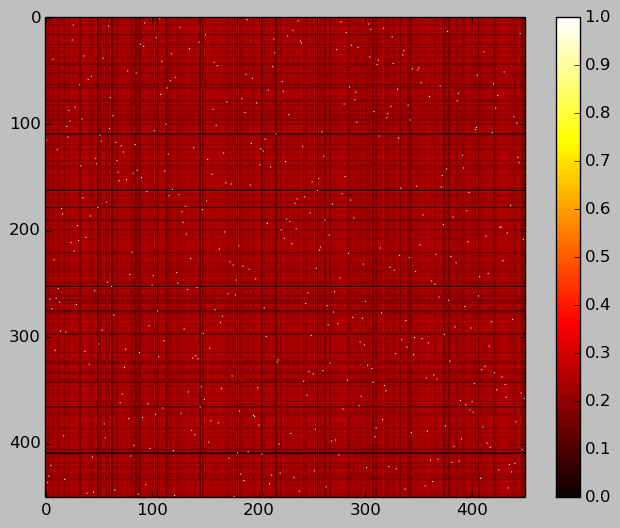

In [109]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(dj, cmap='hot')
plt.colorbar(imgplot, orientation='vertical')
plt.show()

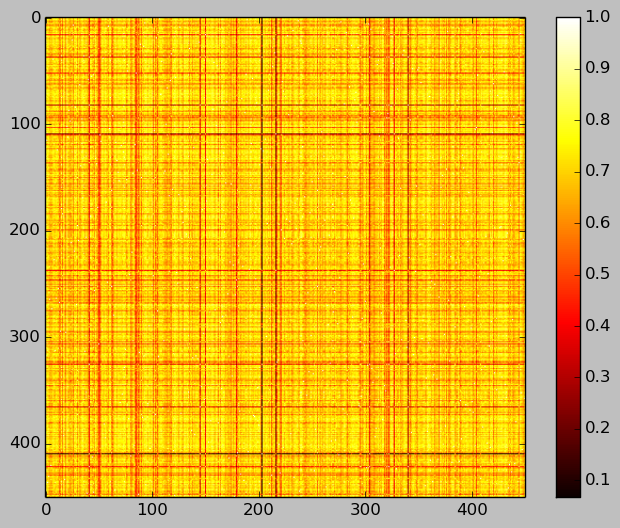

In [110]:
imgcosplot = plt.imshow(dc, cmap='hot')
plt.colorbar(imgcosplot, orientation='vertical')
plt.show()